# Image Classification with CNN using Keras

In [16]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.2.0
Is using GPU? False


In [17]:
#preprocessing data and taking only thre classes
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)#one-hot encoding
    
    return x, y

In [18]:
(x_train,y_train) , (x_test,y_test) =tf.keras.datasets.cifar10.load_data()
x_train,y_train=get_three_classes(x_train,y_train)
x_test,y_test = get_three_classes(x_test,y_test)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


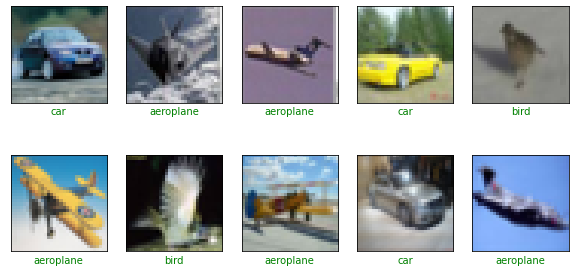

In [19]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x,y,p):
    indices = np.random.choice(range(x.shape[0]),10,replace=False)
    
    x=x[indices]
    y=y[indices]
    p=p[indices]
    
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,1+i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col='green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])],color=col)
        
    plt.show()
    
show_random_examples(x_train,y_train,y_train)

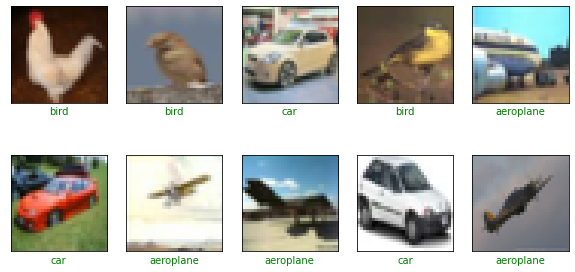

In [20]:
show_random_examples(x_test,y_test,y_test)

In [21]:
#Creating a CNN
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model,num_filters):
        model.add(Conv2D(num_filters,3,activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters,3,activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        return model
                  
    model=tf.keras.models.Sequential()
    model.add(Input(shape=(32,32,3)))
                  
    model=add_conv_block(model,32)
    model=add_conv_block(model,64)
    model=add_conv_block(model,128)
    
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
                  
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',metrics=['accuracy']
    )
        
    return model
        
model= create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 15, 64)       

In [22]:
h = model.fit(x_train/255.,y_train,validation_data=(x_test/255., y_test),epochs=10,batch_size=128,
             callbacks=[
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3),
                 tf.keras.callbacks.ModelCheckpoint(
                     'C:/Users/garvs/Documents/python/image_recog_keras/models/model_{val_accuracy:.3f}.h5',
                     save_best_only=True,save_weights_only=False,
                     monitor='val_accuracy')
                      
                 ]
             )

Epoch 1/10
118/118 [==============================] - 68s 575ms/step - loss: 0.8843 - accuracy: 0.6734 - val_loss: 3.2325 - val_accuracy: 0.3333
Epoch 2/10
118/118 [==============================] - 71s 604ms/step - loss: 0.5553 - accuracy: 0.7740 - val_loss: 2.2180 - val_accuracy: 0.5150
Epoch 3/10
118/118 [==============================] - 71s 600ms/step - loss: 0.4824 - accuracy: 0.8078 - val_loss: 2.1121 - val_accuracy: 0.5147
Epoch 4/10
118/118 [==============================] - 70s 596ms/step - loss: 0.4468 - accuracy: 0.8255 - val_loss: 1.0889 - val_accuracy: 0.6080
Epoch 5/10
118/118 [==============================] - 71s 602ms/step - loss: 0.4071 - accuracy: 0.8392 - val_loss: 0.5776 - val_accuracy: 0.7723
Epoch 6/10
118/118 [==============================] - 71s 605ms/step - loss: 0.3760 - accuracy: 0.8532 - val_loss: 0.3981 - val_accuracy: 0.8483
Epoch 7/10
118/118 [==============================] - 71s 605ms/step - loss: 0.3511 - accuracy: 0.8619 - val_loss: 0.3238 - val_ac

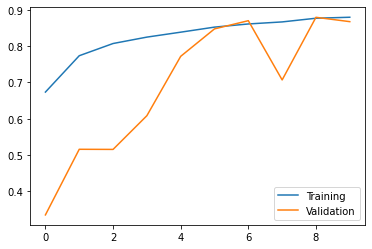

In [23]:
accs = h.history['accuracy']
val_accs=h.history['val_accuracy']

plt.plot(range(10), accs, label='Training')
plt.plot(range(len(accs)),val_accs,label='Validation')
plt.legend()
plt.show()

In [31]:
#load the model with the best accuracy from the location where it is saves
model=tf.keras.models.load_model(r'C:\Users\garvs\Documents\python\image_recog_keras\models\model_0.880.h5')

In [32]:
#use this model to predict values from test dataset
preds=model.predict(x_test/255.)

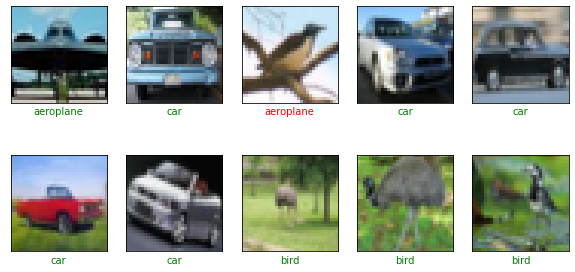

In [33]:
#prediction on random set of values
show_random_examples(x_test,y_test,preds)